# **Курс Специализация Data Science Дипломный проект. Бриф учебного кейса**

# «Модель прогнозирования стоимости жилья для агентства недвижимости»



In [98]:
#импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_regression


from sklearn.model_selection import GridSearchCV
import optuna
import catboost
import xgboost as xgb

## **Отбор признаков**

In [99]:
train_data=pd.read_csv('train_data.csv')

In [100]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281037 entries, 0 to 281036
Data columns (total 72 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   baths                                        281037 non-null  float64
 1   fireplace                                    281037 non-null  bool   
 2   sqft                                         281037 non-null  float64
 3   zipcode                                      281037 non-null  int64  
 4   target                                       281037 non-null  int64  
 5   private_pool                                 281037 non-null  bool   
 6   beds                                         281037 non-null  float64
 7   city                                         281037 non-null  int64  
 8   year built                                   281037 non-null  int64  
 9   heating                                      281037 non-nul

In [101]:
# сформируем матрицу наблюдений и вектор целевой переменной
X = train_data.drop(['target','target_log'], axis=1)
y = train_data['target']
y_log = train_data['target_log']

In [102]:
#  выберем 25 признаков для работы с помощью SelectKBest
selector = feature_selection.SelectKBest(f_regression, k=25)
selector.fit(X, y_log)
columns_freg=selector.get_feature_names_out()

In [103]:
columns_freg

array(['baths', 'fireplace', 'sqft', 'zipcode', 'private_pool', 'beds',
       'year built', 'cooling', 'parking', 'remodeled',
       'schools_high_rating', 'mean_distance_school', 'state_CA',
       'state_DC', 'state_IN', 'state_MI', 'state_NY', 'state_OH',
       'state_PA', 'state_TX', 'state_WA', 'status_new_foreclosure',
       'property_type_lot/land', 'property_type_mobile',
       'property_type_multi family'], dtype=object)

In [104]:
X=X[columns_freg]

In [105]:
# разобьем выборку на обучающую и валидационную в соотношении 67/33
X_train, X_valid, y_train_log, y_valid_log = train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

In [106]:
# нормализуем данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_valid)

В наших данных присутствуют выбросы, поэтому для оценки качества обучения модели выбрала MAE, также воспользуемся коэффициентом детерминации R^2 для оценки того как хорошо наша модель объясняет вариацию зависимой переменной. Модели будем сравнить с помощью метрики MАE, так как наши данные имеют выбросы, и коэффициента детерминации R. Обучать будем на 25 признаках, выбранных SelectKBest, как наиболее влияющих на нашу целевой признак. Данные обработаем скейлером Minmaxscaler.

## **Решение задачи регрессии: линейная регрессия и деревья решений**

### Линейная регрессия

In [107]:
#создаем модель линейной регрессии
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_scaled, y_train_log)
y_predicted_train = lr_model.predict(X_train_scaled)
y_predicted_test = lr_model.predict(X_test_scaled)

MAE_train = metrics.mean_absolute_error(y_train_log, y_predicted_train)
MAE_test = metrics.mean_absolute_error(y_valid_log, y_predicted_test)
R_train = metrics.r2_score(y_train_log, y_predicted_train)
R_test = metrics.r2_score(y_valid_log, y_predicted_test)
print('MAE train: %.2f' % MAE_train)
print('MAE test: %.2f' % MAE_test)
print('R train: %.2f' % R_train)
print('R test: %.2f' % R_test)



MAE train: 0.45
MAE test: 0.45
R train: 0.55
R test: 0.55


### Полиноминоминальная регрессия

In [108]:
#создаем модель полиноминальной регрессии
poly = preprocessing.PolynomialFeatures(degree=2)
poly.fit_transform(X_train_scaled)

X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

model_poly=linear_model.LinearRegression()
model_poly.fit(X_train_poly,y_train_log)


y_predicted_train = model_poly.predict(X_train_poly)
y_predicted_test = model_poly.predict(X_test_poly)

MAE_train = metrics.mean_absolute_error(y_train_log, y_predicted_train)
MAE_test = metrics.mean_absolute_error(y_valid_log, y_predicted_test)
R_train = metrics.r2_score(y_train_log, y_predicted_train)
R_test = metrics.r2_score(y_valid_log, y_predicted_test)
print('MAE train: %.2f' % MAE_train)
print('MAE test: %.2f' % MAE_test)
print('R train: %.2f' % R_train)
print('R test: %.2f' % R_test)


MAE train: 0.39
MAE test: 0.39
R train: 0.67
R test: 0.67


Так как в наших данных большой разброс значений, то попробуем улучшить метрики регулязацией L2

In [109]:
# подберем параметры с помощью Optuna

def optuna_ridge(trial):
  alpha2 = trial.suggest_float('alpha', 0.1, 10)
  ridge = linear_model.Ridge(alpha=alpha2, max_iter=10000)
  ridge.fit(X_train_poly, y_train_log)
  score = metrics.mean_squared_error(y_train_log, ridge.predict(X_train_poly))

  return score


study = optuna.create_study(study_name="ridge", direction='minimize')
study.optimize(optuna_ridge, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

best_alpha_2=study.best_params.get('alpha')

# создаём модель линейной регрессии c L2-регуляризацией
ridge = linear_model.Ridge(alpha=best_alpha_2, max_iter=10000)
# обучаем модель
ridge.fit(X_train_poly, y_train_log)

y_predicted_train =ridge.predict(X_train_poly)
y_predicted_test = ridge.predict(X_test_poly)

MAE_train = metrics.mean_absolute_error(y_train_log, y_predicted_train)
MAE_test = metrics.mean_absolute_error(y_valid_log, y_predicted_test)
R_train = metrics.r2_score(y_train_log, y_predicted_train)
R_test = metrics.r2_score(y_valid_log, y_predicted_test)
print('MAE train: %.2f' % MAE_train)
print('MAE test: %.2f' % MAE_test)
print('R train: %.2f' % R_train)
print('R test: %.2f' % R_test)

[I 2023-10-26 20:44:37,776] A new study created in memory with name: ridge


[I 2023-10-26 20:44:38,715] Trial 0 finished with value: 0.2975953939814612 and parameters: {'alpha': 5.692038434248299}. Best is trial 0 with value: 0.2975953939814612.
[I 2023-10-26 20:44:39,627] Trial 1 finished with value: 0.2995997089996859 and parameters: {'alpha': 8.093755712099263}. Best is trial 0 with value: 0.2975953939814612.
[I 2023-10-26 20:44:40,540] Trial 2 finished with value: 0.29780350842785774 and parameters: {'alpha': 5.908329116396479}. Best is trial 0 with value: 0.2975953939814612.
[I 2023-10-26 20:44:41,476] Trial 3 finished with value: 0.29134274097052765 and parameters: {'alpha': 1.6534651040827426}. Best is trial 3 with value: 0.29134274097052765.
[I 2023-10-26 20:44:42,374] Trial 4 finished with value: 0.30066701571259435 and parameters: {'alpha': 9.692916553130706}. Best is trial 3 with value: 0.29134274097052765.
[I 2023-10-26 20:44:43,342] Trial 5 finished with value: 0.29445421898073926 and parameters: {'alpha': 3.1726527217915708}. Best is trial 3 with

Наилучшие значения гиперпараметров {'alpha': 0.10653396606448368}
MAE train: 0.39
MAE test: 0.39
R train: 0.67
R test: 0.67


### Решающee дерево

In [110]:
# для дерева используем GridSearch

param = {'max_depth': range(7, 20)
        }

grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeRegressor(random_state=42),
    param_grid=param,
    cv=5,
    n_jobs = -1
)
%time grid_search_tree.fit(X_train_scaled, y_train_log)

print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

MAE_train = metrics.mean_absolute_error(y_train_log, y_predicted_train)
MAE_test = metrics.mean_absolute_error(y_valid_log, y_predicted_test)
R_train = metrics.r2_score(y_train_log, y_predicted_train)
R_test = metrics.r2_score(y_valid_log, y_predicted_test)
print('MAE train: %.2f' % MAE_train)
print('MAE test: %.2f' % MAE_test)
print('R train: %.2f' % R_train)
print('R test: %.2f' % R_test)

CPU times: total: 3 s
Wall time: 36 s
Наилучшие значения гиперпараметров: {'max_depth': 18}
MAE train: 0.39
MAE test: 0.39
R train: 0.67
R test: 0.67


## **Решение задачи регрессии: ансамблевые методы**

### Случайный лес

In [111]:
#Создаем объект класса случайный лес
rf_model = ensemble.RandomForestRegressor(
    n_estimators = 200,
    max_depth = 10,
    criterion = 'squared_error',
    min_samples_leaf = 10,
    random_state=42,
    verbose=True)

rf_model.fit(X_train_scaled, y_train_log)
y_predicted_train = rf_model.predict(X_train_scaled)
y_predicted_test = rf_model.predict(X_test_scaled)

MAE_train = metrics.mean_absolute_error(y_train_log, y_predicted_train)
MAE_test = metrics.mean_absolute_error(y_valid_log, y_predicted_test)
R_train = metrics.r2_score(y_train_log, y_predicted_train)
R_test = metrics.r2_score(y_valid_log, y_predicted_test)
print('MAE train: %.2f' % MAE_train)
print('MAE test: %.2f' % MAE_test)
print('R train: %.2f' % R_train)
print('R test: %.2f' % R_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   34.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


MAE train: 0.37
MAE test: 0.37
R train: 0.70
R test: 0.69


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.3s


### Градиентный бустинг

In [112]:
# cоздаем объект класса градиентный бустинг
gb = ensemble.GradientBoostingRegressor(
    learning_rate = 0.5,
    n_estimators = 100,
    max_depth=6,
    min_samples_split = 20,
    random_state=42,
    verbose=True
)

gb.fit(X_train_scaled, y_train_log)

y_predicted_train = gb.predict(X_train_scaled)
y_predicted_test = gb.predict(X_test_scaled)

MAE_train = metrics.mean_absolute_error(y_train_log, y_predicted_train)
MAE_test = metrics.mean_absolute_error(y_valid_log, y_predicted_test)
R_train = metrics.r2_score(y_train_log, y_predicted_train)
R_test = metrics.r2_score(y_valid_log, y_predicted_test)
print('MAE train: %.2f' % MAE_train)
print('MAE test: %.2f' % MAE_test)
print('R train: %.2f' % R_train)
print('R test: %.2f' % R_test)

      Iter       Train Loss   Remaining Time 
         1           0.5232           56.75s
         2           0.4021           55.50s
         3           0.3379           53.99s
         4           0.3020           53.43s
         5           0.2798           52.04s
         6           0.2623           51.59s
         7           0.2498           50.48s
         8           0.2380           50.11s
         9           0.2282           49.45s
        10           0.2241           48.69s
        20           0.1840           42.83s
        30           0.1650           37.48s
        40           0.1524           32.03s
        50           0.1443           26.55s
        60           0.1369           21.11s
        70           0.1312           15.76s
        80           0.1256           10.49s
        90           0.1217            5.23s
       100           0.1186            0.00s
MAE train: 0.24
MAE test: 0.26
R train: 0.86
R test: 0.83


In [113]:
# задаем пространства поиска гиперпараметров через Optuna
'''def optuna_gb(trial):

  learning_rate = trial.suggest_float('learning_rate',  0.01, 1)
  n_estimators = trial.suggest_int('n_estimators', 80, 100)
  max_depth=trial.suggest_int('max_depth', 4, 6)
  min_samples_split = trial.suggest_int('min_samples_split', 10, 20)

  # создаем модель
  model = ensemble.GradientBoostingRegressor( learning_rate=learning_rate,
                                             n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split = min_samples_split,
                                              random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train_log)
  score = metrics.mean_squared_error(y_train_log, model.predict(X_train_scaled))


  return score

random_state=42

study = optuna.create_study(study_name="GradientBoosting", direction='minimize')
study.optimize(optuna_gb, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

model_rf = ensemble.GradientBoostingRegressor(**study.best_params,random_state=random_state)
model_rf.fit(X_train_scaled, y_train_log)

y_predicted_train =model_rf.predict(X_train_scaled)
y_predicted_test = model_rf.predict(X_test_scaled)

MAE_train = metrics.mean_absolute_error(y_train_log, y_predicted_train)
MAE_test = metrics.mean_absolute_error(y_valid_log, y_predicted_test)
R_train = metrics.r2_score(y_train_log, y_predicted_train)
R_test = metrics.r2_score(y_valid_log, y_predicted_test)
print('MAE train: %.2f' % MAE_train)
print('MAE test: %.2f' % MAE_test)
print('R train: %.2f' % R_train)
print('R test: %.2f' % R_test)'''

'def optuna_gb(trial):\n\n  learning_rate = trial.suggest_float(\'learning_rate\',  0.01, 1)\n  n_estimators = trial.suggest_int(\'n_estimators\', 80, 100)\n  max_depth=trial.suggest_int(\'max_depth\', 4, 6)\n  min_samples_split = trial.suggest_int(\'min_samples_split\', 10, 20)\n\n  # создаем модель\n  model = ensemble.GradientBoostingRegressor( learning_rate=learning_rate,\n                                             n_estimators=n_estimators,\n                                              max_depth=max_depth,\n                                              min_samples_split = min_samples_split,\n                                              random_state=random_state)\n  # обучаем модель\n  model.fit(X_train_scaled, y_train_log)\n  score = metrics.mean_squared_error(y_train_log, model.predict(X_train_scaled))\n\n\n  return score\n\nrandom_state=42\n\nstudy = optuna.create_study(study_name="GradientBoosting", direction=\'minimize\')\nstudy.optimize(optuna_gb, n_trials=20)\n\nprint("На

Так как лучшие метрики показал градиентный бустинг, то попробуем алгоритмы машинного обучения, основанные на бустинге xgboost и catboost

#### Xgboost

In [114]:
best_features_names=list(columns_freg)

In [115]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log)
dtest = xgb.DMatrix(X_test_scaled,label=y_valid_log)

c:\Users\senm\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [116]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
            'booster' : 'gbtree', 'objective': 'reg:squarederror'
           }

watchlist = [(dtrain, 'train'), (dtest, 'test')]

# Обучаем модель XGBoost
model_xgb = xgb.train(
    params=xgb_pars,
    dtrain=dtrain,
    num_boost_round=300,
    evals=watchlist,
    early_stopping_rounds=20,
    maximize=False,
    verbose_eval=10
)

y_predicted_train =model_xgb.predict(dtrain)
y_predicted_test = model_xgb.predict(dtest)

MAE_train = metrics.mean_absolute_error(y_train_log, y_predicted_train)
MAE_test = metrics.mean_absolute_error(y_valid_log, y_predicted_test)
R_train = metrics.r2_score(y_train_log, y_predicted_train)
R_test = metrics.r2_score(y_valid_log, y_predicted_test)
print('MAE train: %.2f' % MAE_train)
print('MAE test: %.2f' % MAE_test)
print('R train: %.2f' % R_train)
print('R test: %.2f' % R_test)

[0]	train-rmse:0.88900	test-rmse:0.88606
[10]	train-rmse:0.63728	test-rmse:0.63801
[20]	train-rmse:0.55268	test-rmse:0.55551
[30]	train-rmse:0.51296	test-rmse:0.51669
[40]	train-rmse:0.48698	test-rmse:0.49134
[50]	train-rmse:0.46999	test-rmse:0.47510
[60]	train-rmse:0.45942	test-rmse:0.46528
[70]	train-rmse:0.45228	test-rmse:0.45883
[80]	train-rmse:0.44669	test-rmse:0.45379
[90]	train-rmse:0.43986	test-rmse:0.44777
[100]	train-rmse:0.43450	test-rmse:0.44319
[110]	train-rmse:0.42982	test-rmse:0.43908
[120]	train-rmse:0.42599	test-rmse:0.43593
[130]	train-rmse:0.42381	test-rmse:0.43417
[140]	train-rmse:0.42066	test-rmse:0.43162
[150]	train-rmse:0.41735	test-rmse:0.42888
[160]	train-rmse:0.41530	test-rmse:0.42739
[170]	train-rmse:0.41214	test-rmse:0.42484
[180]	train-rmse:0.40959	test-rmse:0.42280
[190]	train-rmse:0.40707	test-rmse:0.42097
[200]	train-rmse:0.40498	test-rmse:0.41935
[210]	train-rmse:0.40337	test-rmse:0.41813
[220]	train-rmse:0.40130	test-rmse:0.41657
[230]	train-rmse:0.399

#### Catboost

Попробуем сначала обучить модель catboost с нашими обработанными данными, потом запустим обучение модели на необработанных данных, т.к. catboost может обрабатывать категорийные признаки.

In [117]:
model_cb = catboost.CatBoostRegressor(random_seed=42)
model_cb.fit(X_train, y_train_log)

y_predicted_train = model_cb.predict(X_train)
y_predicted_test = model_cb.predict(X_valid)

MAE_train = metrics.mean_absolute_error(y_train_log, y_predicted_train)
MAE_test = metrics.mean_absolute_error(y_valid_log, y_predicted_test)
R_train = metrics.r2_score(y_train_log, y_predicted_train)
R_test = metrics.r2_score(y_valid_log, y_predicted_test)
print('MAE train: %.2f' % MAE_train)
print('MAE test: %.2f' % MAE_test)
print('R train: %.2f' % R_train)
print('R test: %.2f' % R_test)

Learning rate set to 0.093671
0:	learn: 0.8931885	total: 16.2ms	remaining: 16.2s
1:	learn: 0.8582318	total: 33ms	remaining: 16.4s
2:	learn: 0.8280471	total: 48.9ms	remaining: 16.3s
3:	learn: 0.8025813	total: 65.2ms	remaining: 16.2s
4:	learn: 0.7798646	total: 81.1ms	remaining: 16.1s
5:	learn: 0.7595218	total: 96.7ms	remaining: 16s
6:	learn: 0.7417726	total: 113ms	remaining: 16s
7:	learn: 0.7259240	total: 129ms	remaining: 16s
8:	learn: 0.7118916	total: 144ms	remaining: 15.9s
9:	learn: 0.6996665	total: 160ms	remaining: 15.8s
10:	learn: 0.6887680	total: 177ms	remaining: 15.9s
11:	learn: 0.6787311	total: 192ms	remaining: 15.8s
12:	learn: 0.6692981	total: 208ms	remaining: 15.8s
13:	learn: 0.6608588	total: 223ms	remaining: 15.7s
14:	learn: 0.6534286	total: 242ms	remaining: 15.9s
15:	learn: 0.6459631	total: 260ms	remaining: 16s
16:	learn: 0.6394387	total: 276ms	remaining: 16s
17:	learn: 0.6329399	total: 295ms	remaining: 16.1s
18:	learn: 0.6278678	total: 311ms	remaining: 16.1s
19:	learn: 0.6218

In [118]:
# загрузим очищенный и предобработанный датасет
cat_data=pd.read_csv('temp_data.csv')

In [119]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281037 entries, 0 to 281036
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   street                281037 non-null  object 
 1   baths                 281037 non-null  float64
 2   fireplace             281037 non-null  bool   
 3   sqft                  281037 non-null  float64
 4   zipcode               281037 non-null  int64  
 5   state                 281037 non-null  object 
 6   target                281037 non-null  int64  
 7   private_pool          281037 non-null  bool   
 8   status_new            281037 non-null  object 
 9   property_type         281037 non-null  object 
 10  beds                  281037 non-null  float64
 11  city                  281037 non-null  object 
 12  year built            281037 non-null  int64  
 13  heating               281037 non-null  bool   
 14  cooling               281037 non-null  bool   
 15  

In [120]:
def preprocess__data(data):
    
    drop_columns = ['street', 'lotsize','year_built_group','beds']
    cols_to_as_category = ['zipcode','city','year built','state','status_new','property_type','mean_distance_school']

    data['target_log']=np.log(data['target']+1)
    #data['sqft']=np.log(data['sqft']+1)
    
    
    data['mean_distance_school'] = data['mean_distance_school'].replace(-1, 'unknown').astype('str')
    data['year built'] = data['year built'].replace(-1, 'unknown').astype('str')
    data['zipcode'] = data['zipcode'].astype('str')
    
    for col in cols_to_as_category:
        data[col] = data[col].astype('category')
   
    data = data.drop(drop_columns, axis=1)

    return data

cat_data=preprocess__data(cat_data)


In [121]:
types = cat_data.dtypes
cat_features = list(types[types == 'category'].index)
cat_features

['zipcode',
 'state',
 'status_new',
 'property_type',
 'city',
 'year built',
 'mean_distance_school']

In [122]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281037 entries, 0 to 281036
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   baths                 281037 non-null  float64 
 1   fireplace             281037 non-null  bool    
 2   sqft                  281037 non-null  float64 
 3   zipcode               281037 non-null  category
 4   state                 281037 non-null  category
 5   target                281037 non-null  int64   
 6   private_pool          281037 non-null  bool    
 7   status_new            281037 non-null  category
 8   property_type         281037 non-null  category
 9   city                  281037 non-null  category
 10  year built            281037 non-null  category
 11  heating               281037 non-null  bool    
 12  cooling               281037 non-null  bool    
 13  parking               281037 non-null  bool    
 14  remodeled             281037 non-nul

In [123]:
X = cat_data.drop(['target','target_log'], axis=1)
y = cat_data['target']
y_log = cat_data['target_log']

X_train, X_valid, y_train_log, y_valid_log = train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42)

In [124]:
model_cat = catboost.CatBoostRegressor(random_seed=42,cat_features=cat_features)
model_cat.fit(X_train, y_train_log)

y_predicted_train = model_cat.predict(X_train)
y_predicted_test = model_cat.predict(X_valid)

MAE_train = metrics.mean_absolute_error(y_train_log, y_predicted_train)
MAE_test = metrics.mean_absolute_error(y_valid_log, y_predicted_test)
R_train = metrics.r2_score(y_train_log, y_predicted_train)
R_test = metrics.r2_score(y_valid_log, y_predicted_test)
print('MAE train: %.2f' % MAE_train)
print('MAE test: %.2f' % MAE_test)
print('R train: %.2f' % R_train)
print('R test: %.2f' % R_test)

Learning rate set to 0.093671
0:	learn: 0.8861265	total: 165ms	remaining: 2m 44s
1:	learn: 0.8441551	total: 308ms	remaining: 2m 33s
2:	learn: 0.8076764	total: 450ms	remaining: 2m 29s
3:	learn: 0.7750069	total: 574ms	remaining: 2m 23s
4:	learn: 0.7424894	total: 751ms	remaining: 2m 29s
5:	learn: 0.7126954	total: 922ms	remaining: 2m 32s
6:	learn: 0.6851552	total: 1.06s	remaining: 2m 29s
7:	learn: 0.6607844	total: 1.21s	remaining: 2m 30s
8:	learn: 0.6397338	total: 1.38s	remaining: 2m 31s
9:	learn: 0.6211884	total: 1.54s	remaining: 2m 32s
10:	learn: 0.6049436	total: 1.68s	remaining: 2m 30s
11:	learn: 0.5900860	total: 1.82s	remaining: 2m 30s
12:	learn: 0.5762391	total: 2.01s	remaining: 2m 32s
13:	learn: 0.5640150	total: 2.22s	remaining: 2m 36s
14:	learn: 0.5542032	total: 2.39s	remaining: 2m 37s
15:	learn: 0.5437914	total: 2.54s	remaining: 2m 35s
16:	learn: 0.5353958	total: 2.69s	remaining: 2m 35s
17:	learn: 0.5275632	total: 2.85s	remaining: 2m 35s
18:	learn: 0.5211577	total: 2.98s	remaining:

## **Выбор модели**

In [125]:
# сведем все результаты тестируемых моделей
results={'Линейная регрессия':['',0.45,0.45,0.55,0.55],
         'Полиномиальная регрессия':['', 0.39,0.39,0.67,0.67],
         'Линейная регрессия с L2 регулязацией':['', 0.39,0.39,0.67,0.67],
         'Решающее дерево':['GridSearch',0.40,0.40,0.66,0.66],
         'Случайный лес':['', 0.37,0.37,0.7,0.69],
         'Градиентный бустинг':['', 0.24,0.26,0.86,0.83],
         'Градиентный бустинг c оптимизацией':['Optuna',0.23,0.26,0.88,0.83],
         'Xgboost':['', 0.27,0.28,0.83,0.81],
         'Catboost':['', 0.28,0.28,0.82,0.81],
         'Catboost без обработки категориальных данных':['', 0.23,0.24,0.88,0.86]
}
df=pd.DataFrame.from_dict(results,orient='index',columns=['Оптимизация','MAE train','MAE test','R^2 train','R^2 test'])
display(df)

,Оптимизация,MAE train,MAE test,R^2 train,R^2 test
Линейная регрессия,,0.45,0.45,0.55,0.55
Полиномиальная регрессия,,0.39,0.39,0.67,0.67
Линейная регрессия с L2 регулязацией,,0.39,0.39,0.67,0.67
Решающее дерево,GridSearch,0.40,0.40,0.66,0.66
Случайный лес,,0.37,0.37,0.70,0.69
Градиентный бустинг,,0.24,0.26,0.86,0.83
Градиентный бустинг c оптимизацией,Optuna,0.23,0.26,0.88,0.83
Xgboost,,0.27,0.28,0.83,0.81
Catboost,,0.28,0.28,0.82,0.81
Catboost без обработки категориальных данных,,0.23,0.24,0.88,0.86


Наилучшие результаты показали модели градиентного бустинга:
- подбор параметров немного улучшил метрики, но видно, что произошел процесс переобучения, так как на тестовой выборке показатели не изменились.
- модель Catboost без обработки категориальных данных encoders показала лучшие результаты, чем на обработных данных. Данный алгоритм отлично подходит к нашей задаче, так как в основном датасет состоит из категориальных данных. Поэтому лучшей моделью будем считать Catboost.

Посмотрим какие признаки модель посчитала более важными для обучения.

Text(0.5, 1.0, 'Feature Importance')

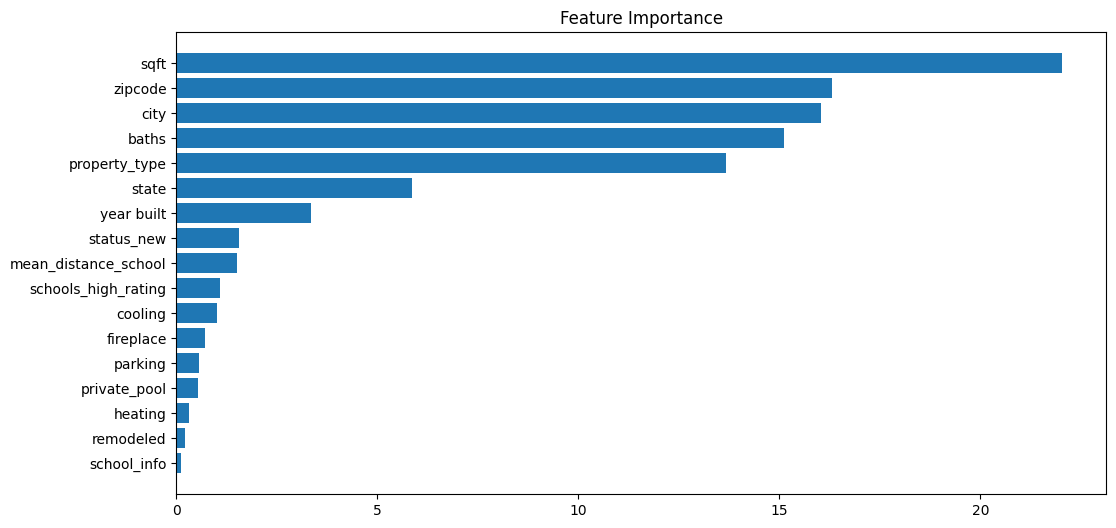

In [126]:
feature_importance = model_cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_valid.columns)[sorted_idx])
plt.title('Feature Importance')


In [ ]:
import pickle

# Сохранение выбранной обученной модели в файл pickle
pickle.dump(model_cat, open("model_cat.pkl", "wb"))

## **Построение прогноза**

In [127]:
# переведем предсказание в реальные единицы и посмотрим какую ошибку они дают
y_predicted_train = model_cat.predict(X_train)
y_predicted_test = model_cat.predict(X_valid)

y_valid_log_cat = np.exp(y_valid_log - 1)
y_predicted_test_cat = np.exp(y_predicted_test - 1)

print(f'Качество предсказания по MАE для Catboosting {metrics.mean_absolute_error(y_valid_log_cat, y_predicted_test_cat):.0f} долл.')

Качество предсказания по MАE для Catboosting 49948 долл.


Тестирование модели на вебсервисе


<image src="./images/test.jpeg">